In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras import layers

In [2]:
path = '/content/Dataset'
if not os.path.exists(path):
    ! unzip Dataset
else: 
    print('Already Extracted')

Archive:  Dataset.zip
   creating: Dataset/
   creating: Dataset/Class 1/
  inflating: Dataset/Class 1/0.png   
  inflating: Dataset/Class 1/1.png   
  inflating: Dataset/Class 1/10.png  
  inflating: Dataset/Class 1/100.png  
  inflating: Dataset/Class 1/101.png  
  inflating: Dataset/Class 1/102.png  
  inflating: Dataset/Class 1/103.png  
  inflating: Dataset/Class 1/104.png  
  inflating: Dataset/Class 1/105.png  
  inflating: Dataset/Class 1/106.png  
  inflating: Dataset/Class 1/107.png  
  inflating: Dataset/Class 1/108.png  
  inflating: Dataset/Class 1/109.png  
  inflating: Dataset/Class 1/11.png  
  inflating: Dataset/Class 1/110.png  
  inflating: Dataset/Class 1/111.png  
  inflating: Dataset/Class 1/112.png  
  inflating: Dataset/Class 1/113.png  
  inflating: Dataset/Class 1/114.png  
  inflating: Dataset/Class 1/115.png  
  inflating: Dataset/Class 1/116.png  
  inflating: Dataset/Class 1/117.png  
  inflating: Dataset/Class 1/118.png  
  inflating: Dataset/Class 1/119.

In [3]:
# Load the data
data_dir = '/content/Dataset'
class_names = ['1', '2', '3', '4', '5']
num_classes = len(class_names)

# Create a function to load the data
def load_data(data_dir, class_names):
    images = []
    labels = []
    for class_name in class_names:
        class_dir = data_dir + '/' + 'Class ' + class_name
        for image_path in tf.io.gfile.glob(class_dir + '/*.png'):
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) #, cv2.IMREAD_GRAYSCALE
            images.append(img)
            labels.append(class_names.index(class_name) + 1)
    return np.array(images), np.array(labels)

In [4]:
# Load the data
images, labels = load_data(data_dir, class_names)

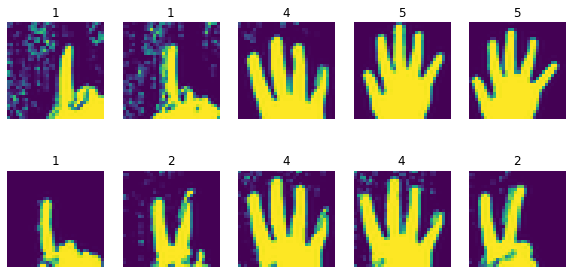

In [5]:
# Visualize the data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()
i = 0
for num in (np.random.randint(0, len(images), 10)):
    axes[i].imshow(images[num])
    axes[i].set_title(labels[num])
    axes[i].axis('off')
    i += 1
plt.show()

In [6]:
print('Images shape:', images.shape)
print(images.shape[0], 'train samples')

Images shape: (1005, 32, 32)
1005 train samples


In [7]:
img_rows = 32
img_cols = 32
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

In [8]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)
    model.summary()

    return model
    # noise = Input(shape=(latent_dim,))
    # img = model(noise)
    # return Model(noise, img)

In [9]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()

    return model
    # img = Input(shape=img_shape)
    # validity = model(img)
    # return Model(img, validity)

In [10]:
optimizer = Adam(0.0002, 0.5)

# build discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [11]:
from numpy.random import choice
from numpy.random import random
 
# example of smoothing class=0 to [0.0, 0.3]
def smooth_negative_labels(y):
 return y + random(y.shape) * 0.3

 # example of smoothing class=1 to [0.7, 1.2]
def smooth_positive_labels(y):
 return y - 0.3 + (random(y.shape) * 0.5)

# randomly flip some labels
def noisy_labels(y, p_flip):
 # determine the number of labels to flip
 n_select = int(p_flip * y.shape[0])
 # choose labels to flip
 flip_ix = choice([i for i in range(y.shape[0])], size=n_select)
 # invert the labels in place
 y[flip_ix] = 1 - y[flip_ix]
 return y

In [12]:
g_losses = []
d_losses = []
d_acces = []
def train(epochs, batch_size=128, save_interval=50):
    os.makedirs('images', exist_ok=True)
    
    # Load the dataset
    X_train, y_train = images, labels

    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    valid = noisy_labels(valid, 0.05)
    valid = smooth_positive_labels(valid)
    fake = np.zeros((batch_size, 1))
    fake = smooth_negative_labels(fake)

    for epoch in range(epochs):
        # Select a random real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combined.train_on_batch(noise, valid)

        g_losses.append(g_loss)
        d_losses.append(D_loss[0])
        d_acces.append(D_loss[1])
        
        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            save_imgs(epoch)

In [13]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("/content/images/%d.png" % epoch)
    plt.close()

In [14]:
start = time.time()

train(epochs=5000, batch_size=32, save_interval=500)

end = time.time()
elapsed_train_time = 'elapsed training time: {} min, {} sec '.format(int((end - start) / 60),
                                                                     int((end - start) % 60))
print(elapsed_train_time)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 15ms/step
500 [D loss: 0.479881, acc.: 0.00%] [G loss: 0.822647]
1/1 [==============================] - 0s 13ms/step
1000 [D loss: 0.699253, acc.: 0.00%] [G loss: 0.645474]
1/1 [==============================] - 0s 13ms/step
1500 [D loss: 0.621566, acc.: 0.00%] [G loss: 0.774974]
1/1 [==============================] - 0s 15ms/step
2000 [D loss: 0.621054, acc.: 0.00%] [G loss: 0.882085]
1/1 [==============================] - 0s 12ms/step
2500 [D loss: 3.075160, acc.: 0.00%] [G loss: 5.486988]
1/1 [==============================] - 0s 13ms/step
3000 [D loss: 0.556106, acc.: 0.00%] [G loss: 0.815087]
1/1 [==============================] - 0s 15ms/step
3500 [D loss: 0.649185, acc.: 0.00%] [G loss: 0.913509]
1/1 [==============================] - 0s 18ms/step
4000 [D loss: 0.560841, acc.: 0.00%] [G loss: 0.868151]
1/1 [==============================] - 0s 12ms/step
4500 [D loss: 0.637031, acc.: 0.00

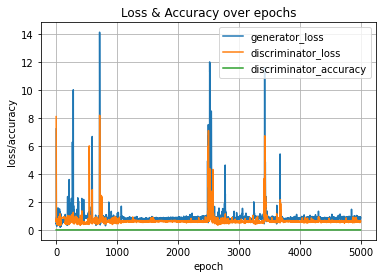

In [15]:
plt.figure()
plt.plot(g_losses)
plt.plot(d_losses)
plt.plot(d_acces)
plt.title('Loss & Accuracy over epochs')
plt.xlabel('epoch')
plt.ylabel('loss/accuracy')
plt.legend(['generator_loss','discriminator_loss', 'discriminator_accuracy'])
plt.grid()
plt.show()

In [16]:
!zip -r /content/file.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/0.png (deflated 10%)
  adding: content/images/3000.png (deflated 7%)
  adding: content/images/500.png (deflated 8%)
  adding: content/images/4000.png (deflated 8%)
  adding: content/images/1000.png (deflated 8%)
  adding: content/images/2000.png (deflated 7%)
  adding: content/images/2500.png (deflated 8%)
  adding: content/images/1500.png (deflated 7%)
  adding: content/images/4500.png (deflated 7%)
  adding: content/images/3500.png (deflated 8%)
